In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import torch.optim as optim
import pandas as pd
import seaborn as sns
import numpy as np
import csv
import os

from torchvision import datasets, transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.font_manager import FontProperties
from tqdm import tqdm

# For reproducibility
torch.cuda.manual_seed(42)
torch.manual_seed(42)

In [2]:
import requests

class Kuzushijidataset():
    """
    class credz to https://github.com/elisiojsj/Kuzushiji-49/blob/master/Kuzushiji-49.ipynb
    """
    
    resources = [
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz"),
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz"),
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz"),
    ("http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz")]
    
    training_file_imgs = "k49-train-imgs.npz"
    training_file_labels = "k49-train-labels.npz"
    test_file_imgs = "k49-test-imgs.npz"
    test_file_labels = "k49-test-labels.npz"
    data_dir = "k49-dataset"
    
   
    def __init__(self, data_dir="k49-dataset", train=True, transform=None, download=True):
        self.data_dir = data_dir
        
        if download:
            self.download(train)
            
        train_data_imgs = os.path.join(self.data_dir, self.training_file_imgs)
        train_data_imgs = np.load(train_data_imgs)
        train_data_imgs = train_data_imgs.f.arr_0

        train_data_labels = os.path.join(self.data_dir, self.training_file_labels)
        train_data_labels = np.load(train_data_labels)
        train_data_labels = train_data_labels.f.arr_0

        test_data_imgs = os.path.join(self.data_dir, self.test_file_imgs)
        test_data_imgs = np.load(test_data_imgs)
        test_data_imgs = test_data_imgs.f.arr_0
        
        test_data_labels = os.path.join(self.data_dir, self.test_file_labels)
        test_data_labels = np.load(test_data_labels)
        test_data_labels = test_data_labels.f.arr_0
        
        self.transform = transform
        
        if train:
            self.data = train_data_imgs
            self.targets = train_data_labels
        else:
            self.data = test_data_imgs
            self.targets = test_data_labels


    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.targets[idx])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img, mode='L') # mode='L' - (8-bit pixels, black and white)

        if self.transform:
            img = self.transform(img)
        
        return img, target        
      
    def download(self, train):
        # download the Kuzushiji-49 dataset if it doesn't exist
        if self._check_exists():
            if train:
                print('Train dataset already exists!')
            else:
                print('Test dataset already exists!')
            return

        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
        for url in self.resources:
            filename = url.rpartition('/')[2]
            print('Downloading: ', filename)
            myfile = requests.get(url, allow_redirects=True)
            open(os.path.join(self.data_dir, filename), 'wb').write(myfile.content)

        print('All files downloaded!')
        

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.data_dir, self.training_file_imgs)) and
                os.path.exists(os.path.join(self.data_dir, self.training_file_labels)) and
                os.path.exists(os.path.join(self.data_dir, self.test_file_imgs)) and
                os.path.exists(os.path.join(self.data_dir, self.test_file_labels)))

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     # transforms.Grayscale(num_output_channels=3),
     # k49 is 28x28 
     # transforms.Resize((84, 83)),
     transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = Kuzushijidataset("k49-dataset", train=True, download=True, transform=transform)
test_data = Kuzushijidataset("k49-dataset", train=False, download=True, transform=transform)

print("Train dataset size: ", len(train_data))
print("Test dataset size: ", len(test_data))

Train dataset already exists!
Test dataset already exists!
Train dataset size:  232365
Test dataset size:  38547


In [4]:
classes = ['あ - a', 'い - i', 'う - u', 'え - e', 'お - o', 
       'か - ka', 'き - ki', 'く - ku', 'け - ke', 'こ - ko', 
       'さ - sa', 'し - shi', 'す - su', 'せ - se', 'そ - so', 
       'た - ta', 'ち - chi', 'つ - tsu', 'て - te', 'と - to', 
       'な - na', 'に - ni', 'ぬ - nu', 'ね - ne', 'の - no',
       'は - ha', 'ひ - hi', 'ふ - fu', 'へ - he', 'ほ - ho',
       'ま - ma', 'み - mi', 'む - mu', 'め - me', 'も - mo',
       'や - ya', 'ゆ - yu', 'よ - yo', 
       'ら - ra', 'り - ri', 'る - ru', 'れ - re', 'ろ - ro',
       'わ - wa', 'ゐ - wi', 'ゑ - we', 'を - wo', 'ん - n', 'ゝ']

In [5]:
{i: classes[i] for i in range(len(classes))}

{0: 'あ - a',
 1: 'い - i',
 2: 'う - u',
 3: 'え - e',
 4: 'お - o',
 5: 'か - ka',
 6: 'き - ki',
 7: 'く - ku',
 8: 'け - ke',
 9: 'こ - ko',
 10: 'さ - sa',
 11: 'し - shi',
 12: 'す - su',
 13: 'せ - se',
 14: 'そ - so',
 15: 'た - ta',
 16: 'ち - chi',
 17: 'つ - tsu',
 18: 'て - te',
 19: 'と - to',
 20: 'な - na',
 21: 'に - ni',
 22: 'ぬ - nu',
 23: 'ね - ne',
 24: 'の - no',
 25: 'は - ha',
 26: 'ひ - hi',
 27: 'ふ - fu',
 28: 'へ - he',
 29: 'ほ - ho',
 30: 'ま - ma',
 31: 'み - mi',
 32: 'む - mu',
 33: 'め - me',
 34: 'も - mo',
 35: 'や - ya',
 36: 'ゆ - yu',
 37: 'よ - yo',
 38: 'ら - ra',
 39: 'り - ri',
 40: 'る - ru',
 41: 'れ - re',
 42: 'ろ - ro',
 43: 'わ - wa',
 44: 'ゐ - wi',
 45: 'ゑ - we',
 46: 'を - wo',
 47: 'ん - n',
 48: 'ゝ'}

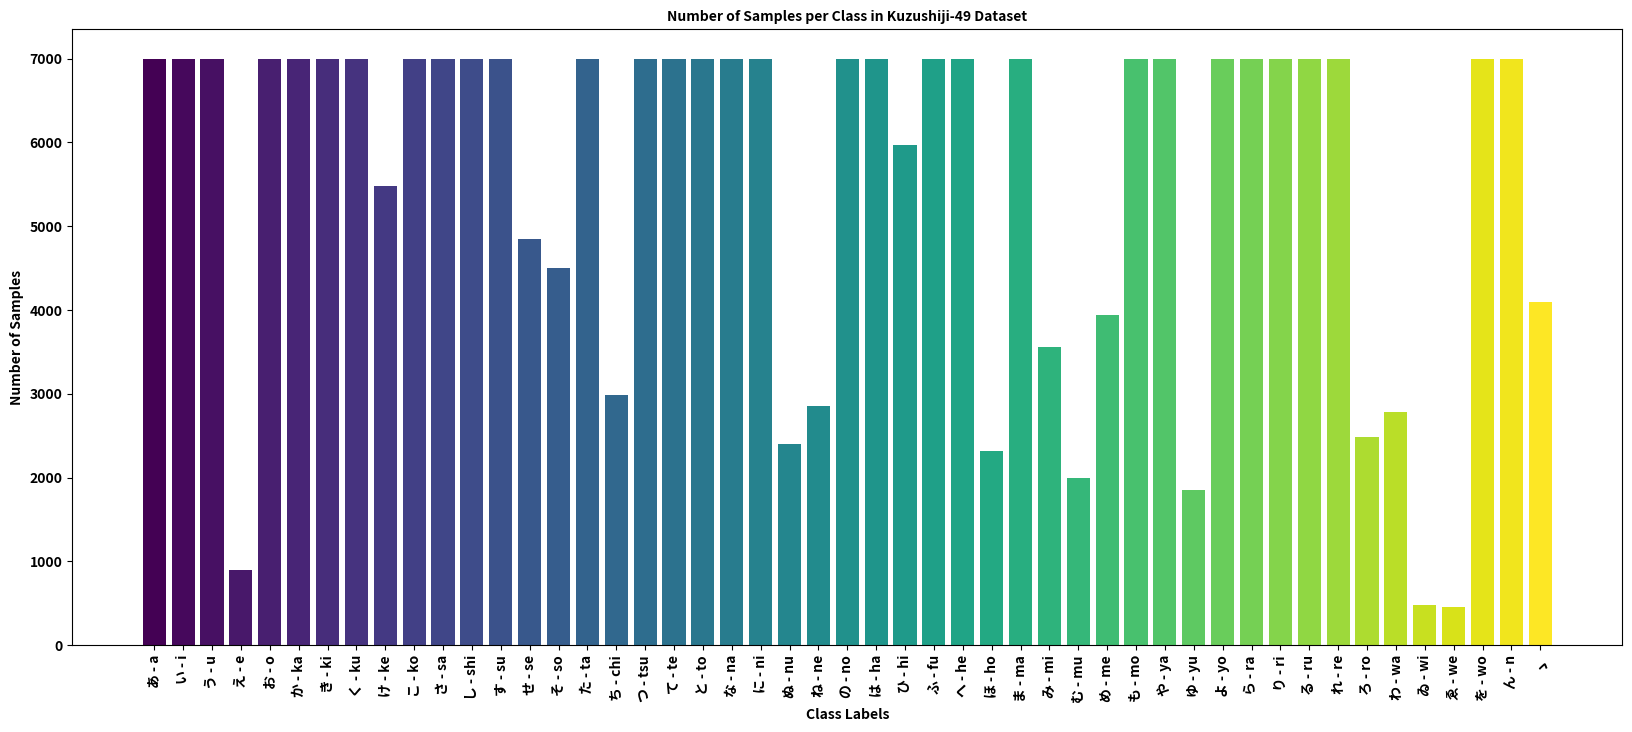

In [6]:
train_labels = train_data.targets
test_labels = test_data.targets

# Combine the labels into a single array
all_labels = np.concatenate((train_labels, test_labels))

# Count the number of samples for each class
num_classes = np.max(all_labels) + 1  # Assuming classes are labeled from 0 to max
samples_per_class = np.bincount(all_labels, minlength=num_classes)

# Create the plot
fp = FontProperties(fname='static/NotoSansJP-Bold.ttf')

color_map = plt.colormaps['viridis'](np.linspace(0, 1, num_classes))

# Create the plot
plt.figure(figsize=(20, 8))
bars = plt.bar(classes, samples_per_class, color=color_map)  # Apply different colors to each bar
plt.xlabel('Class Labels', fontproperties=fp)
plt.ylabel('Number of Samples', fontproperties=fp)
plt.title('Number of Samples per Class in Kuzushiji-49 Dataset', fontproperties=fp)
plt.xticks(rotation=90, fontproperties=fp)  # Apply font to x-ticks
plt.yticks(fontproperties=fp)  # Apply font to y-ticks
plt.show()

In [7]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

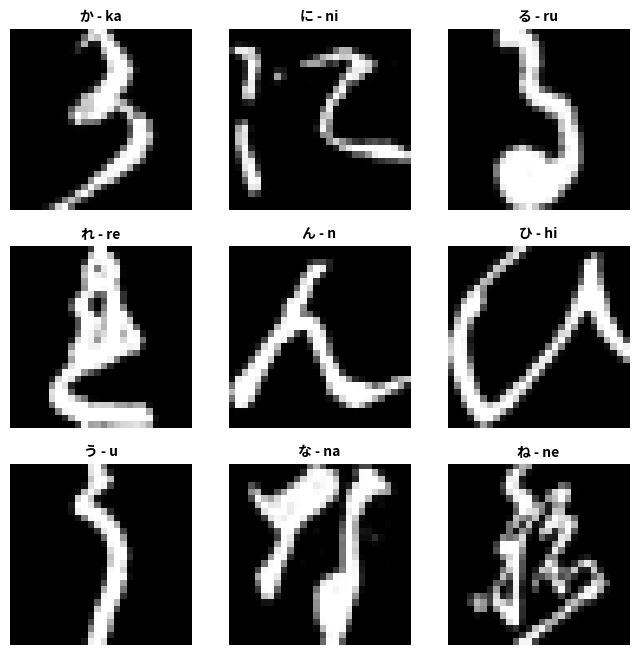

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
fp = FontProperties(fname='static/NotoSansJP-Bold.ttf')
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label], fontproperties=fp)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
# Define MobileNet model
class MobileNet(nn.Module):
    def __init__(self, num_classes=49):
        # https://www.researchgate.net/publication/369777559_A_Robust_Residual_Shrinkage_Balanced_Network_for_Image_Recognition_from_Japanese_Historical_Documents
        super(MobileNet, self).__init__()
        self.mobilenet = models.mobilenet_v3_large(weights=None)
        # self.mobilenet = models.mobilenet_v3_large(weights="MobileNet_V3_Large_Weights.DEFAULT")
        self.mobilenet.features[0][0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.mobilenet.classifier[3] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

In [10]:
model = MobileNet()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Have to decrease lr on higher epochs (>200)
criterion = nn.CrossEntropyLoss()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

epochs = 30
losses = []
for epoch in range(epochs):
    model.train()

    
    # for custom progress bar
    with tqdm(train_loader, unit="batch") as tepoch:
        epoch_loss = 0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            data, target = data.to(device), target.to(device) # move input to GPU
            out = model(data)
            loss = criterion(out, target)
            acc = multi_acc(out, target)
            epoch_loss += loss.item()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            tepoch.set_postfix(loss = loss.item(), accuracy = acc.item()) # show loss and accuracy per batch of data
    losses.append(epoch_loss)


Epoch 1:  16%|█▌        | 287/1816 [00:11<01:01, 24.68batch/s, accuracy=73, loss=1.02] 


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'mobilenet-hiragana.pth')

In [ ]:
sns.set_style("dark")
sns.lineplot(data=losses).set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.show()

In [ ]:
# predict on testing data samples (the accuracy here is batch accuracy)
y_pred_list = []
y_true_list = []
model.eval()
with torch.inference_mode():
    with tqdm(test_loader, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            acc = multi_acc(y_test_pred, labels)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            tepoch.set_postfix(accuracy = acc.item())
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

In [ ]:
flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])
        
print(f"number of testing samples results: {len(flat_pred)}")

In [ ]:
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

In [ ]:
# plot confusion matrix
# idx2class = {i: i for i in range(len(classes))}
# fp = FontProperties(fname='static/NotoSansJP-Bold.ttf')
# confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, flat_pred)).rename(columns=idx2class, index=idx2class)
# plt.figure(figsize=(15, 12))
# sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
# plt.show()